In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.simple_keypoint_dataset import SimpleKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path
pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/synthetic_cabin_ir/A_Pillar_Codriver')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
bbox_path = dataset_root_path / 'person_detection_results'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True)
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/linear_model/synthetic_cabin_ir/A_Pillar_Codriver/predicted_2d/'


train_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    bbox_file=(bbox_path / 'human_detection_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True,
    is_normalize_to_bbox=True,
    bbox_format='xyxy'
)
val_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_val.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_val.json').as_posix(),
    bbox_file=(bbox_path / 'human_detection_val.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True,
    is_normalize_to_bbox=True,
    bbox_format='xyxy'
)
test_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_test.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_test.json').as_posix(),
    bbox_file=(bbox_path / 'human_detection_test.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True,
    is_normalize_to_bbox=True,
    bbox_format='xyxy'
)

print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)

model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)


if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234
/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


train_dataset 37499 val_dataset 6250 test_dataset 6251


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 1748.9218711853027


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 2925 batches: 276.1187761894658
val MPJPE from: 6208 samples : 62.48540058732033


Validation: 0it [00:00, ?it/s]

check #2
training loss from 2925 batches: 63.3905856566042
val MPJPE from: 6208 samples : 39.466485381126404


Validation: 0it [00:00, ?it/s]

check #3
training loss from 2925 batches: 53.26751351483867
val MPJPE from: 6208 samples : 37.46896982192993


Validation: 0it [00:00, ?it/s]

check #4
training loss from 2925 batches: 50.820174661711754
val MPJPE from: 6208 samples : 36.706745624542236


Validation: 0it [00:00, ?it/s]

check #5
training loss from 2925 batches: 49.37911354705819
val MPJPE from: 6208 samples : 35.47779098153114


Validation: 0it [00:00, ?it/s]

check #6
training loss from 2925 batches: 47.950695297147476
val MPJPE from: 6208 samples : 36.04885935783386


Validation: 0it [00:00, ?it/s]

check #7
training loss from 2925 batches: 46.723248357446785
val MPJPE from: 6208 samples : 35.81928461790085


Validation: 0it [00:00, ?it/s]

check #8
training loss from 2925 batches: 45.64835731545065
val MPJPE from: 6208 samples : 35.25146096944809


Validation: 0it [00:00, ?it/s]

check #9
training loss from 2925 batches: 44.879737422507034
val MPJPE from: 6208 samples : 34.74915027618408


Validation: 0it [00:00, ?it/s]

check #10
training loss from 2925 batches: 44.181466471945114
val MPJPE from: 6208 samples : 34.07207876443863


Validation: 0it [00:00, ?it/s]

check #11
training loss from 2925 batches: 43.753696815070946
val MPJPE from: 6208 samples : 34.83322635293007


Validation: 0it [00:00, ?it/s]

check #12
training loss from 2925 batches: 43.240626868274475
val MPJPE from: 6208 samples : 34.696564078330994


Validation: 0it [00:00, ?it/s]

check #13
training loss from 2925 batches: 42.81846643895165
val MPJPE from: 6208 samples : 34.01366248726845


Validation: 0it [00:00, ?it/s]

check #14
training loss from 2925 batches: 42.56557202492005
val MPJPE from: 6208 samples : 34.24513339996338


Validation: 0it [00:00, ?it/s]

check #15
training loss from 2925 batches: 42.34694269732532
val MPJPE from: 6208 samples : 34.39266234636307


Validation: 0it [00:00, ?it/s]

check #16
training loss from 2925 batches: 42.119464152134384
val MPJPE from: 6208 samples : 34.37154367566109


Validation: 0it [00:00, ?it/s]

check #17
training loss from 2925 batches: 41.95298394713647
val MPJPE from: 6208 samples : 33.82427617907524


Validation: 0it [00:00, ?it/s]

check #18
training loss from 2925 batches: 41.8099958405026
val MPJPE from: 6208 samples : 34.07907113432884


Validation: 0it [00:00, ?it/s]

check #19
training loss from 2925 batches: 41.65608102312455
val MPJPE from: 6208 samples : 34.26437824964523


Validation: 0it [00:00, ?it/s]

check #20
training loss from 2925 batches: 41.599528249512375
val MPJPE from: 6208 samples : 34.1825969517231


Validation: 0it [00:00, ?it/s]

check #21
training loss from 2925 batches: 41.50612910843303
val MPJPE from: 6208 samples : 34.2247299849987


Validation: 0it [00:00, ?it/s]

check #22
training loss from 2925 batches: 41.45139781583069
val MPJPE from: 6208 samples : 34.05335918068886


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)

In [3]:
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/linear_model/synthetic_cabin_ir/A_Pillar_Codriver/predicted_2d/lightning_logs/version_2/checkpoints/epoch=84-step=49725.ckpt
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/linear_model/synthetic_cabin_ir/A_Pillar_Codriver/predicted_2d/lightning_logs/version_2/checkpoints/epoch=84-step=49725.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 35.72407179074888
PJPE
                     PJPE
nose            25.729732
left_eye        25.193661
right_eye       24.493344
left_ear        22.420274
right_ear       19.505699
left_shoulder   18.023779
right_shoulder  18.023780
left_elbow      75.507025
right_elbow     64.036529
left_wrist      51.775433
right_wrist     44.950901
left_hip        41.132449
right_hip       33.620328
activities_mpjpe:
{}
test mpjpe: 35.72407179074888


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │     35.72407179074888     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 35.72407179074888}]

In [4]:
trainer.model.test_history[0]['pjpe']

,PJPE
nose,25.729732
left_eye,25.193661
right_eye,24.493344
left_ear,22.420274
right_ear,19.505699
left_shoulder,18.023779
right_shoulder,18.023780
left_elbow,75.507025
right_elbow,64.036529
left_wrist,51.775433


In [5]:
trainer.model.test_history[0]['mpjpe']

35.72407179074888

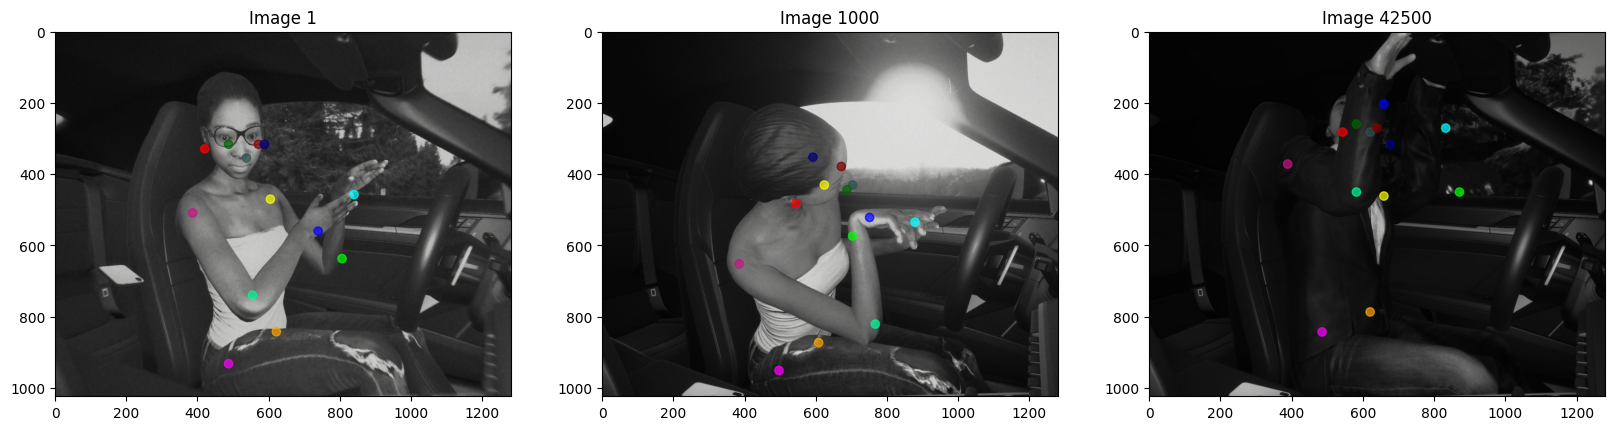

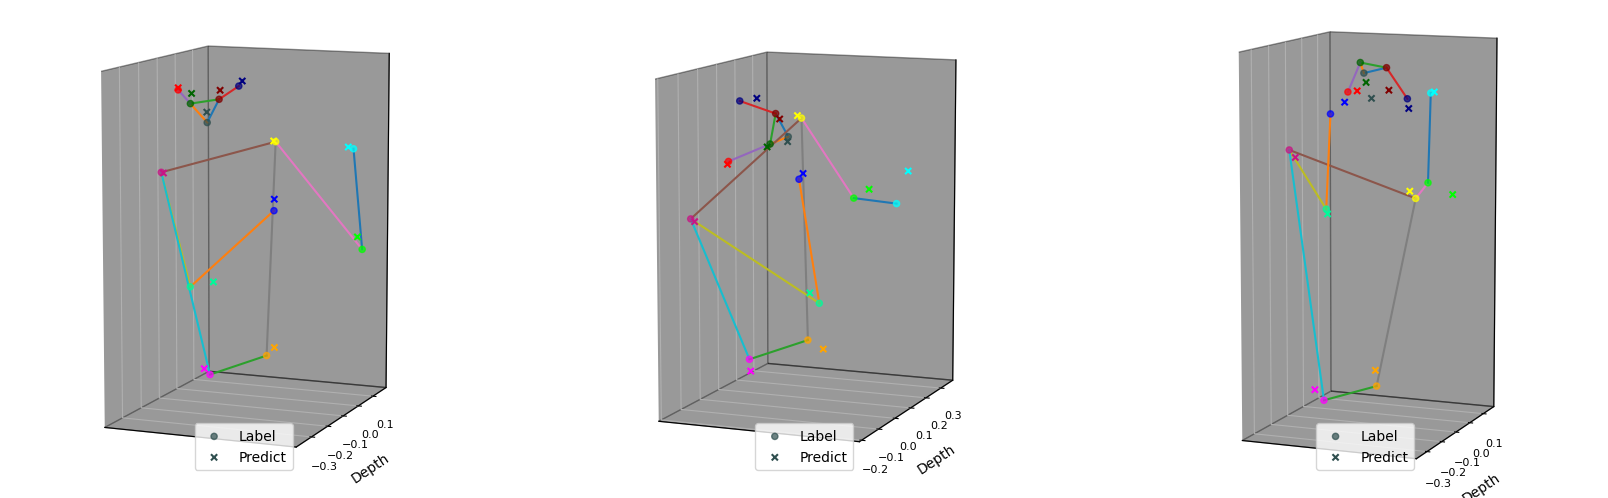

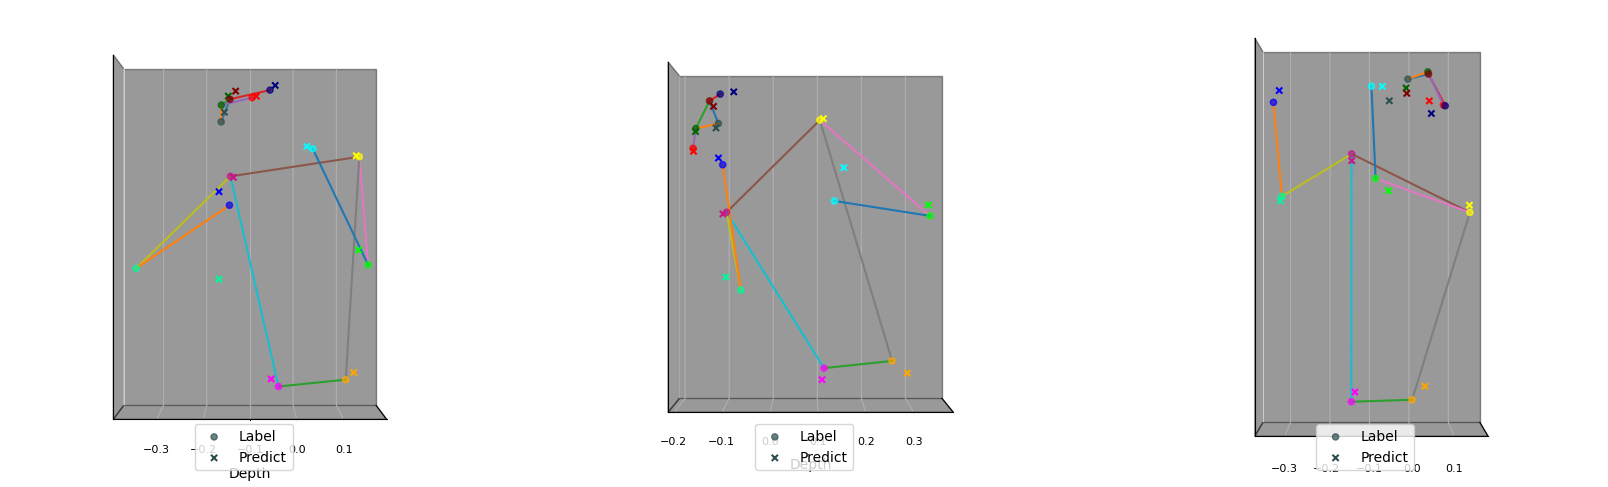

In [7]:
plot_samples(
    dataset_root_path,
    trainer.model,
    test_loader,
    'test',
    img_figsize=(20, 10),
    plot_figsize=(20.5, 10),
    sample_idices=[1, 1000, 5000]
)